<a href="https://colab.research.google.com/github/sergekamanzi/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Import Libraries and Download NLTK Resources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from pandas.errors import ParserError

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Dataset and Check for Missing Values

In [9]:
# Load dataset from local file
try:
    data = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8', engine='c')
except ParserError:
    print("ParserError encountered with C engine. Trying Python engine...")
    data = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8', engine='python')

data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
# Verify dataset columns
print("Dataset Columns:", data.columns)

# Check for missing values
missing_values = data.isnull().sum()
missing_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})
print("\nMissing Values:")
print(missing_df)

# Handle missing values
data['review'] = data['review'].fillna('')
data = data.dropna(subset=['sentiment'])

Dataset Columns: Index(['review', 'sentiment'], dtype='object')

Missing Values:
      Column  Missing Values
0     review               0
1  sentiment               0


# Data Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply text cleaning
data['cleaned_review'] = data['review'].apply(clean_text)

# Convert sentiment labels to binary (positive=1, negative=0)
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Verify sentiment conversion
print("\nSentiment Value Counts:")
print(data['sentiment'].value_counts())


Sentiment Value Counts:
sentiment
1    25000
0    25000
Name: count, dtype: int64


# Data Visualization

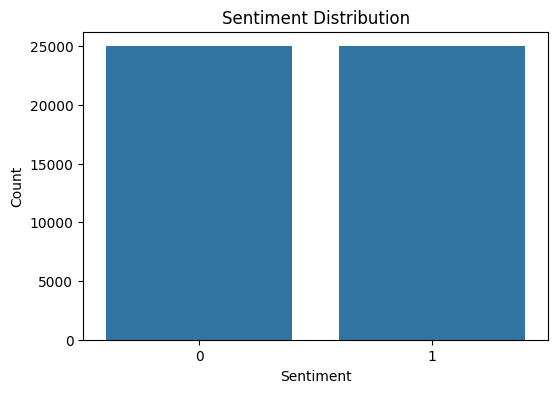

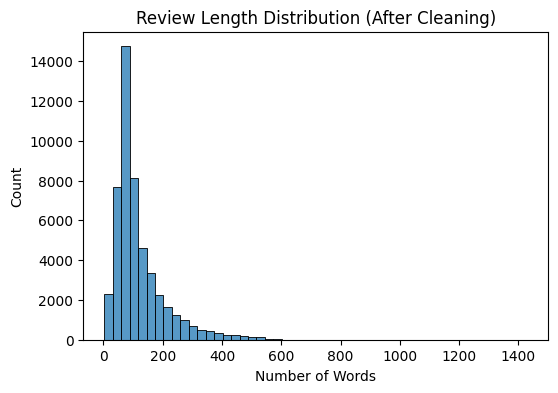

In [12]:
# Visualization - Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Visualization - Review Length Distribution
data['review_length'] = data['cleaned_review'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(6,4))
sns.histplot(data['review_length'], bins=50)
plt.title('Review Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# Data Splitting and TF-IDF Vectorization

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
max_features = 5000
tfidf = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression Model (MODEL1 )

In [14]:
lr_results = []
C_values = [0.01, 0.1, 1.0]
solvers = ['liblinear', 'lbfgs']

for C in C_values:
    for solver in solvers:
        model_lr = LogisticRegression(C=C, solver=solver, max_iter=1000)
        model_lr.fit(X_train_tfidf, y_train)
        y_pred = model_lr.predict(X_test_tfidf)
        lr_results.append({
            'C': C,
            'Solver': solver,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })

# Display Logistic Regression results
lr_results_df = pd.DataFrame(lr_results)
print("\nLogistic Regression Experiment Results:")
print(lr_results_df)
lr_results_df.to_csv('/content/lr_results.csv', index=False)

# Train final Logistic Regression model (best parameters: C=1.0, solver='liblinear')
model_lr = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)
print("\nFinal Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")



Logistic Regression Experiment Results:
      C     Solver  Accuracy  Precision    Recall  F1-Score
0  0.01  liblinear    0.8346   0.816533  0.866442  0.840747
1  0.01      lbfgs    0.8341   0.815534  0.866839  0.840404
2  0.10  liblinear    0.8714   0.856410  0.894820  0.875194
3  0.10      lbfgs    0.8711   0.855923  0.894820  0.874939
4  1.00  liblinear    0.8864   0.877978  0.899583  0.888649
5  1.00      lbfgs    0.8865   0.877855  0.899980  0.888780

Final Logistic Regression Metrics:
Accuracy: 0.8864
Precision: 0.8780
Recall: 0.8996
F1-Score: 0.8886


# Logistic Regression Visualizations

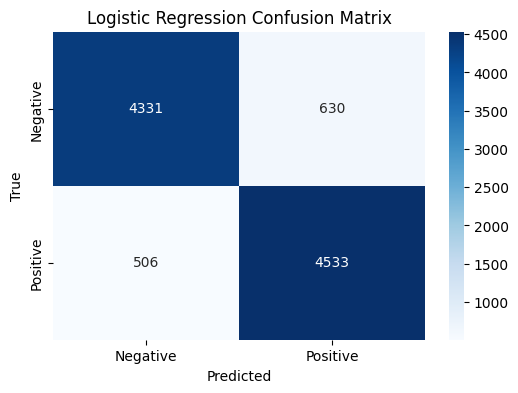

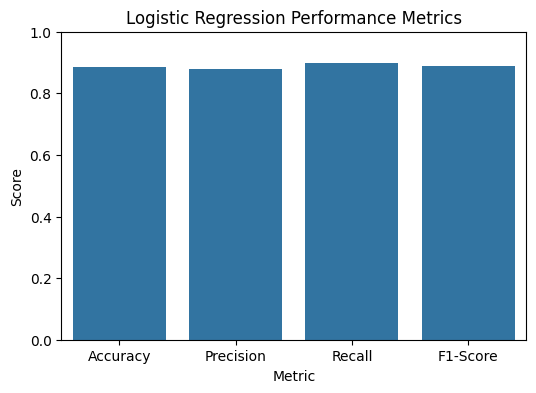

In [15]:
# Visualization: Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualization: Performance Metrics Bar Plot
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr)
    ]
})
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('Logistic Regression Performance Metrics')
plt.ylim(0, 1)
plt.show()

# LSTM Model Preparation(MODEL 2)

In [17]:
# Tokenization and Padding
max_words = 10000
max_len = 100  # Using your max_len
tokenizer = Tokenizer(num_words=max_words)
# Since X_tfidf is already numerical, we'll assume data['cleaned_review'] contains the raw text
tokenizer.fit_on_texts(data['cleaned_review'])
X_train_seq = tokenizer.texts_to_sequences(data['cleaned_review'])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

# Split data for LSTM using the sentiment column as the target
# The target variable 'y' was not defined, use data['sentiment'] instead
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_train_pad, data['sentiment'], test_size=0.2, random_state=42)

# Define hyperparameter experiments
experiments = [
    {'units': 64, 'dropout': 0.3, 'learning_rate': 0.001},
    {'units': 128, 'dropout': 0.4, 'learning_rate': 0.001},
    {'units': 64, 'dropout': 0.3, 'learning_rate': 0.0001}
]

# Train and evaluate LSTM models
results = []
for params in experiments:
    # Build LSTM model
    model_lstm = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        LSTM(params['units'], dropout=params['dropout'], return_sequences=False),
        Dense(32, activation='relu'),
        Dropout(params['dropout']),
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model_lstm.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    # Train model
    # Use the LSTM-specific training and testing data variables
    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

    # Evaluate model
    # Use the LSTM-specific testing data variables for evaluation and prediction
    loss, accuracy = model_lstm.evaluate(X_test_lstm, y_test_lstm, verbose=0)
    y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int)

    # Store results
    # Use the LSTM-specific testing data variables for metric calculation
    results.append({
        'Units': params['units'],
        'Dropout': params['dropout'],
        'Learning Rate': params['learning_rate'],
        'Accuracy': accuracy,
        'Precision': precision_score(y_test_lstm, y_pred_lstm, zero_division=0),
        'Recall': recall_score(y_test_lstm, y_pred_lstm, zero_division=0),
        'F1': f1_score(y_test_lstm, y_pred_lstm, zero_division=0)
    })

# Convert results to DataFrame
lstm_results = pd.DataFrame(results)

# Print results
print("\nLSTM with TF-IDF and Embedding Metrics:")
print(lstm_results)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 159ms/step - accuracy: 0.7588 - loss: 0.4700 - val_accuracy: 0.8723 - val_loss: 0.3084
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 163ms/step - accuracy: 0.9183 - loss: 0.2179 - val_accuracy: 0.8773 - val_loss: 0.3016
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 144ms/step - accuracy: 0.9415 - loss: 0.1566 - val_accuracy: 0.8685 - val_loss: 0.3495
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 150ms/step - accuracy: 0.9600 - loss: 0.1123 - val_accuracy: 0.8675 - val_loss: 0.4602
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 142ms/step - accuracy: 0.9710 - loss: 0.0842 - val_accuracy: 0.8581 - val_loss: 0.5558
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 262ms/step - accuracy: 0.7644 - loss: 0.4667 - val_accuracy: 0.8780 - val_loss: 0.2933
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 263ms/step - accuracy: 0.9139 - loss: 0.2289 - val_accuracy: 0.8764 - val_loss: 0.3158
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 152s 282ms/step - accuracy: 0.9358 - loss: 0.1697 - val_accuracy: 0.8673 - val_loss: 0.3670
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 283ms/step - accuracy: 0.9567 - loss: 0.1237 - val_accuracy: 0.8656 - val_loss: 0.3971
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 262ms/step - accuracy: 0.9625 - loss: 0.1100 - val_accuracy: 0.8664 - val_loss: 0.4699
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 168ms/step - accuracy: 0.6165 - loss: 0.6489 - val_accuracy: 0.8631 - val_loss: 0.3449
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 166ms/step - accuracy: 0.8849 - loss: 0.3057 - val_accuracy: 0.8726 - val_loss: 0.3023
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.9104 - loss: 0.2357 - val_accuracy: 0.8792 - val_loss: 0.2991
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.9233 - loss: 0.2093 - val_accuracy: 0.8759 - val_loss: 0.3146
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 155ms/step - accuracy: 0.9351 - loss: 0.1821 - val_accuracy: 0.8756 - val_loss: 0.3202
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step

LSTM with TF-IDF and Embedding Metrics:
   Units  Dropout  Learning Rate  Accuracy  Precision    Recall        F1
0     64      0.3         0.0010    0.8649   0.891175  0.833697  0.861479
1    128      0.4         0.0010    0.8729   0.873810  0.873983  0.873896
2     64      0.3         0.0001    0.8813   0.871671 

# LSTM Visualizations

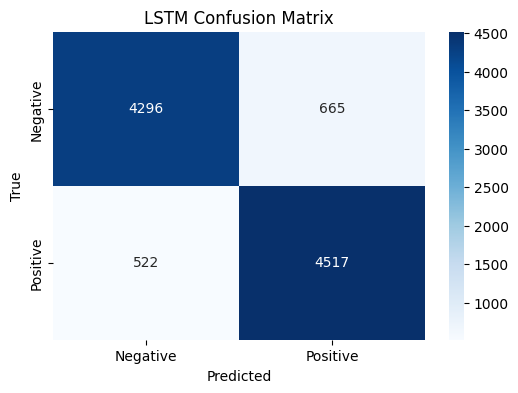

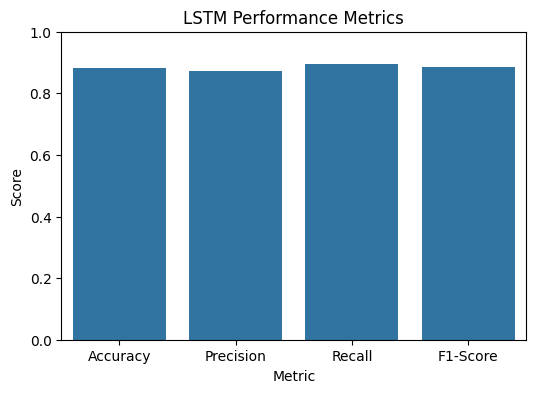

In [18]:
# Visualization: Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualization: Performance Metrics Bar Plot for LSTM
metrics_df_lstm = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy_score(y_test_lstm, y_pred_lstm),
        precision_score(y_test_lstm, y_pred_lstm, zero_division=0),
        recall_score(y_test_lstm, y_pred_lstm, zero_division=0),
        f1_score(y_test_lstm, y_pred_lstm, zero_division=0)
    ]
})
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Score', data=metrics_df_lstm)
plt.title('LSTM Performance Metrics')
plt.ylim(0, 1)
plt.show()